# Benchmark: Area computation

Benchmark comparing area computation across:

* [georust/geo](https://lib.rs/crates/geo) crate
* The [geos C library](https://trac.osgeo.org/geos/), used through high-level Rust bindings via the [geos](https://lib.rs/crates/geos) crate

## Benchmarked operation

Each iteration computes the area of the multi-polygon representing all districts of India a 100,000 times.

# Prerequisites

Generate data:

```sh
cd harness
cargo run --release --bin benchmark_area -- --out-file ../analysis/benchmark_area/data.json --geojson-file ../data/india_districts/polbnda_ind.geojson
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_area/data.json
### Statistics: Raw data
                  qps             
program           geo         geos
count      200.000000   200.000000
mean     10128.866431  4411.654219
std        478.398756   287.172136
min       7493.013140  3031.049789
25%      10169.649654  4446.539457
50%      10267.202988  4521.752330
75%      10322.179071  4549.296242
max      10581.539396  4643.440404


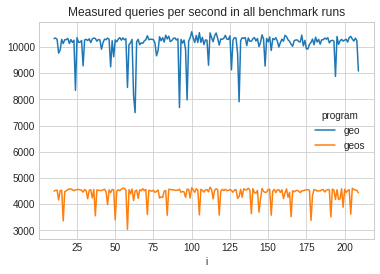

### Statistics: After outlier removal
                  qps             
program           geo         geos
count      176.000000   176.000000
mean     10224.948407  4488.850934
std        203.622310   117.626169
min       9240.380904  3876.316659
25%      10188.356121  4479.900300
50%      10274.705570  4525.882029
75%      10327.234192  4550.010396
max      10581.539396  4643.440404


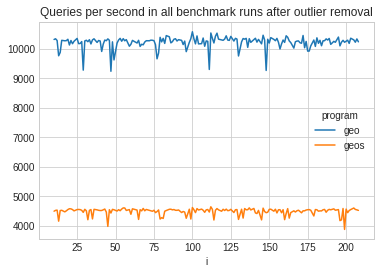

## Ratio of qps compared to geo
                qps
program        geos
count    176.000000
mean       0.439157
std        0.013632
min        0.379121
25%        0.436089
50%        0.440086
75%        0.444854
max        0.480110


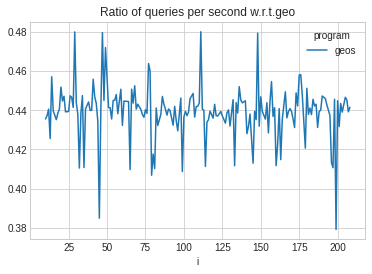

In [2]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data.json')
%run ../common/benchmark_analysis.ipynb

# Performance benchmarking

To generate the following SVG:

```bash
cd harness
cargo build --release

perf record -F 990 -g -o ../analysis/benchmark_area/perf.data ./target/release/benchmark_area --geojson-file ../data/india_districts/polbnda_ind.geojson --out-file /dev/null --iterations 200 --headlong > /dev/null

cd ../analysis/benchmark_area
perf script -i perf.data | ../../third_party/stackcollapse-perf.pl > perf.collapsed-stacks.data
../../third_party/flamegraph.pl perf.collapsed-stacks.data > perf.svg
```

![](./perf.svg)

To dig in further, use
```
perf report -g -i perf.data
```

Observations:
* Over 61% of the time is spent inside `geos::algorithm::Area::ofRingSigned` in libgeos.so - geos area computation proper
  * The descructor `geos::geom::CoordinateArraySequence::~CoordinateArraySequence` in the callgraph is a mystery
* Over 29% of the time is spent inside `geo::algorithm::area::get_linestring_area` -- geo area computation
* geos is *not* slow because of FFI.
